In [32]:
using Pkg
Pkg.activate("..");

In [33]:
using OneClassActiveLearning, SVDD
using Unmarshal, JSON, Serialization
using Plots, OCALPlots
using JuMP, Gurobi
using Random
using MLKernels, MLLabelUtils

include(joinpath(@__DIR__, "..", "scripts", "subspace_util.jl"))
include(joinpath(@__DIR__, "notebook_util.jl"));

solver = with_optimizer(Gurobi.Optimizer; OutputFlag=0, Threads=1);

In [34]:
using ScikitLearn

@sk_import datasets: make_moons
@sk_import datasets: make_circles
@sk_import datasets: make_blobs;

In [35]:
seed = 2
Random.seed!(seed);
C = 0.2
GAMMA = 2
n_inlier = 200
n_outlier = 15;

In [36]:
pyplot()

Plots.PyPlotBackend()

In [37]:
function get_models(data)
    pools_no_feedback = fill(:U, size(data, 2));
    pools_perfect_feedback = copy(pools_no_feedback)
    pools_perfect_feedback[labelmap(labels)[:outlier]] .= :Lout
    pools_perfect_feedback[labelmap(labels)[:inlier]] .= :Lin

    svddneg_no_feedback = SVDDneg(data, pools_no_feedback)
    svddneg_perfect_feedback = SVDDneg(data, pools_perfect_feedback)

    SVDD.initialize!(svddneg_no_feedback, SVDD.SimpleCombinedStrategy(FixedGammaStrategy(MLKernels.GaussianKernel(GAMMA)), FixedCStrategy(C)))
    SVDD.initialize!(svddneg_perfect_feedback, SVDD.SimpleCombinedStrategy(FixedGammaStrategy(MLKernels.GaussianKernel(GAMMA)), FixedCStrategy(C)))

    set_adjust_K!(svddneg_no_feedback, true)
    set_adjust_K!(svddneg_perfect_feedback, true)
    SVDD.fit!(svddneg_no_feedback, solver);
    SVDD.fit!(svddneg_perfect_feedback, solver)
    return(svddneg_no_feedback, svddneg_perfect_feedback)
end

get_models (generic function with 1 method)

### SVDDNeg

In [38]:
psize = (400,200)
pyplot(size=(400, 200))

Plots.PyPlotBackend()

In [39]:
inliers = make_blobs(n_inlier, n_features=2, centers=1, cluster_std = 0.2, center_box=(0.0, 0.0), random_state=seed)[1]'
outliers = make_circles(n_outlier, true, 0.05, random_state=seed)[1]'
dummy_data_s1 = hcat(inliers, outliers)
labels = vcat(fill(:inlier, size(inliers, 2)), fill(:outlier, size(outliers,2)));

In [40]:
svddneg_no_feedback, svddneg_with_feedback = get_models(dummy_data_s1);

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.454392162258955e-14. The sum of adjustments is 9.962985688186099e-11
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.454392162258955e-14. The sum of adjustments is 9.962985688186099e-11
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [41]:
makeplot(m, labels) = plot(m, labels, grid = false, markersize = 8, legend=false, seriescolor=:grays, title = "", axis=false, size = psize)

makeplot (generic function with 1 method)

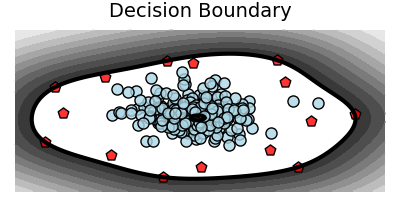

In [42]:
p1 = makeplot(svddneg_no_feedback, labels)

In [43]:
# savefig(plot(p1, title="", markersize = 8), "plots/motivational_example_sub1_svddneg_no_fb.pdf")

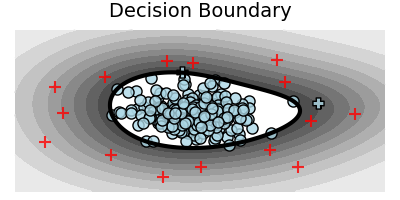

In [44]:
p2 = makeplot(svddneg_with_feedback, labels)

In [45]:
# savefig(plot(p2, title="", legend = :topright, legendfontsize = 12, markersize = 8), "plots/motivational_example_sub1_svddneg_with_fb.pdf");

In [46]:
# plot(p1, p2, layout = 2, title="", axis=false, size = (800, 400))

In [47]:
inliers = make_circles(n_inlier, true, 0.1, random_state=seed)[1]'
outliers = make_blobs(n_outlier, n_features=2, centers=1, cluster_std = 0.2, center_box=(0.0, -1.8), random_state=seed)[1]'
dummy_data_s2 = hcat(inliers, outliers)
labels = vcat(fill(:inlier, size(inliers, 2)), fill(:outlier, size(outliers,2)));

In [48]:
svddneg_no_feedback, svddneg_with_feedback = get_models(dummy_data_s2);

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.882583474838611e-15. The sum of adjustments is 3.5389312301413174e-11
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.882583474838611e-15. The sum of adjustments is 3.5389312301413174e-11
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


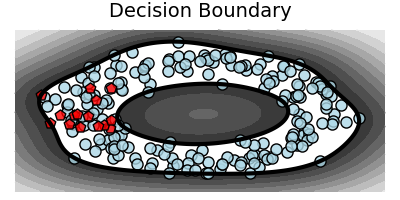

In [49]:
p3 = makeplot(svddneg_no_feedback, labels)

In [50]:
# savefig(plot(p3, title="", markersize = 8), "plots/motivational_example_sub2_svddneg_no_fb.pdf")

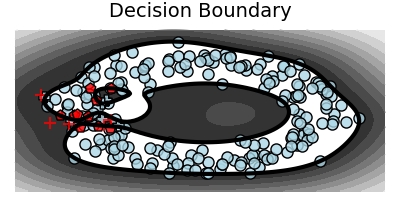

In [51]:
p4 = makeplot(svddneg_with_feedback, labels)

In [52]:
# savefig(plot(p4, title="", markersize = 8), "plots/motivational_example_sub2_svddneg_with_fb.pdf")

### SubSVDD

In [53]:
data = vcat(dummy_data_s1, dummy_data_s2)
subspaces = [[1, 2], [3, 4]]
pools_no_feedback = fill(:U, size(data, 2))

pools_with_feedback = vcat(fill(:Lin, n_inlier), fill(:Lout, n_outlier))

subsvdd_no_feedback = SubSVDD(data, subspaces, pools_no_feedback);
subsvdd_with_feedback = SubSVDD(data, subspaces, pools_with_feedback);
update_strategy = SVDD.FixedWeightStrategy(10., 0.01)
set_param!(subsvdd_with_feedback, Dict(:weight_update_strategy => update_strategy))

query_idx = collect(eachindex(pools_with_feedback))
SVDD.update_with_feedback!(subsvdd_with_feedback, data, pools_with_feedback, query_idx, query_idx, query_idx)

gamma_strategy = FixedGammaStrategy([MLKernels.GaussianKernel(GAMMA), MLKernels.GaussianKernel(GAMMA)])
C_strategy = FixedCStrategy(C)
init_strategy = SVDD.SimpleSubspaceStrategy(gamma_strategy, C_strategy, gamma_scope=Val(:Subspace))

SVDD.initialize!(subsvdd_no_feedback, init_strategy)
SVDD.initialize!(subsvdd_with_feedback, init_strategy)
SVDD.fit!(subsvdd_no_feedback, solver)
SVDD.fit!(subsvdd_with_feedback, solver);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [54]:
make_subspace_plot(m, labels, sid) = plot(m, labels, sid, grid = false, markersize = 8, legend=false, seriescolor=:grays, title = "", axis=false, size = psize)

make_subspace_plot (generic function with 1 method)

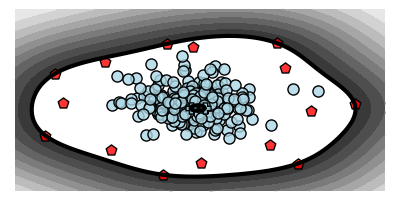

In [55]:
psub_1 = make_subspace_plot(subsvdd_no_feedback, labels, 1)

In [56]:
# savefig(plot(psub_1, title="", markersize = 8), "plots/motivational_example_sub1_subsvdd_no_fb.pdf")

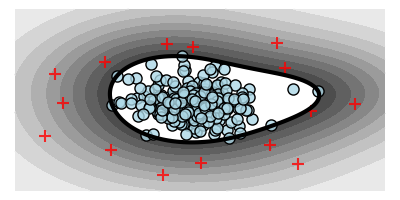

In [57]:
psub_2 = make_subspace_plot(subsvdd_with_feedback, labels, 1)

In [58]:
# savefig(plot(psub_2, title="", legend = :topright, legendfontsize=12, markersize = 8), "plots/motivational_example_sub1_subsvdd_with_fb.pdf")

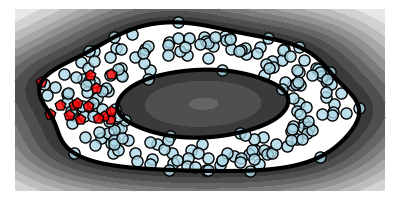

In [59]:
psub_3 = make_subspace_plot(subsvdd_no_feedback, labels, 2)

In [60]:
# savefig(plot(psub_3, title="", markersize = 8), "plots/motivational_example_sub2_subsvdd_no_fb.pdf")

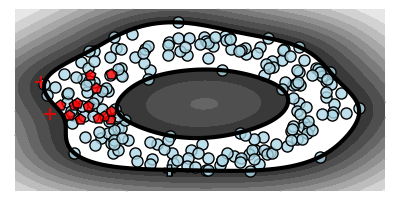

In [61]:
psub_4 = make_subspace_plot(subsvdd_with_feedback, labels, 2)

In [62]:
# savefig(plot(psub_4, title="", markersize = 8), "plots/motivational_example_sub2_subsvdd_with_fb.pdf")